# Cluster-based Local Outlier Factor (CBLOF)

This is based on the paper [Discovering Cluster-based Local Outliers](https://www.sciencedirect.com/science/article/abs/pii/S0167865503000035) along with [pyod python package](https://pyod.readthedocs.io/) and [Anomaly Detection for Dummies](https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1).

In the pyod package, a class named CBLOF is provided and the source code is [here](https://pyod.readthedocs.io/en/latest/_modules/pyod/models/cblof.html). I will compare the code with the paper.

To understand the algorithm, let's first look at the following picture.

![large small clustarts](images/large_small_clusters.png)

In this picture, we have four clusters. $C_1$(Cluster 1) and $C_3$ are small clusters while $C_2$ and $C_4$ large clusters. Any point belongs to one of the four clusters.

The intuition of this algorithm is that: the inliers are in the large groups and outliers in the small groups. If a point is close to any of the large cluster centers, it is considered as inliers. If a point is far away from even the closest cluster center, it is considered as an outlier.

## Find Large and Small Clusters

We denote the side of a cluster as $|C|$. If we sort the clusters from large to small in size. We will have : 

$$ |C_1|\ge|C_2|\ge|C_3|\ge...\ge|C_k|$$

**The Majority**

Two criteria are used to decide the boundary between large and small clusters. The first is to count the points. The large clusters must cover the majority of the points. We add clusters to the large clusters list from the largest to the smallest one. Each time we add one cluster and check if the majority has included. We use $\alpha (0.5<\alpha<1.0)$ to configure the majority rate. Thus we have:

$$|C_1| + |C_2| + ... + |C_b| \ge \alpha * |D|$$

In the pdod package the default for $\alpha$ is 0.9.

**Sudden Shrink**

The other way, I call it sudden shrink. It is to measure the sudden change in cluster size. 

$$|C_b|/|C_{b+1}| \ge \beta$$. 

In the pdod package, the default for $\beta$ is 5.

If one condition is met, $b$ is found. If I were to implement the algorithm, I would iterate from the largest cluster to the smallest. I will quit and return $b$ when one of the conditions is met. 

The pyod package implemented differently. It tries to find a $b$ satisfies both criteria first. If not find, it will use $\alpha$ only, then $\beta$ only.

## Cluster-base Local Outlier Factor

**Euclidean Distance without Weights**

The factor is the distance between any point to is closest large cluster center. Because we already know some of the points belong to one of the large clusters, so we don't have to calculate which cluster center is the closest. Thus we have:

$$
Factor =  min(distance(t, c))
$$

$c$ is the center of cluster $C_i$, $C_i$ is a large cluster.

The pyod package uses the euclidean distance. 

**Weights**

The weight of a point is the size of the closest large cluster. 

Here is what confused me. And, I think the pyod auther made a mistake. 

When pyod does not use weights. It uses distance to measure if a point is abnormal. The larger the distance, the more likely it is abnormal. But when weights are used, the points in the small clusters will be much smaller because they have a small weight. I looked into the paper. The paper says here distance is the similarity measure used in the cluster algorithm. And the in cluster algorithm used in the paper. The larger the similarity, the more likely it is put in the a cluster. 

I think the paper has confused the pdod auther. In the paper it used the *distance* to calculate factor but actually it is not distance, because it says that the distance is the similarity measure used in the cluster algorithm. So the paper means that:

$$Factor = max(similarity(t, c))$$

$c$ is the center of cluster $C_i$, $C_i$ is a large cluster.

# Explore the Data

Here I reuse the data used in Susan Li's article. If my implement is right, I should produce an identical picture. 

In [15]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn import __version__ as sklearn_version

In [16]:
print(pd.__version__)
print(sklearn_version)

1.0.5
0.23.1


In [17]:
df = pd.read_excel("Superstore.xls")

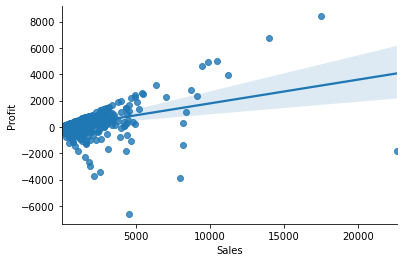

In [18]:
sns.regplot(x="Sales", y="Profit", data=df)
sns.despine();

In [19]:
n_points = df.shape[0]
x1=df['Sales'].values
x2=df['Profit'].values
x1 = x1 - x1.min()
x1 = x1/x1.max()

x2 = x2 - x2.min()
x2 = x2/x2.max()

In [20]:
X=[[a,b] for (a,b) in zip(x1, x2)]
X=np.array(X)

# KMeans

Here I use KMean, the same as pyod. 

In [21]:
km = KMeans(n_clusters=8)

In [22]:
km.fit(X)

KMeans()

In [23]:
cluster_sizes = []
for label in range(km.n_clusters):
    size = sum(km.labels_==label)
    cluster_sizes.append(size)

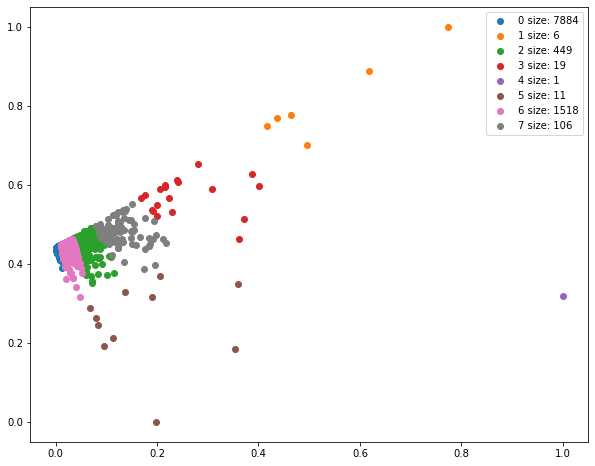

In [24]:
plt.figure(figsize=(10,8))
for label in range(km.n_clusters):
    plt.scatter(x1[km.labels_==label], x2[km.labels_==label], label=f'{label} size: {cluster_sizes[label]}')
plt.legend()
plt.show()

You will see a "small" cluster in the leftmost. Don't be confused it is the largest cluster in terms of cluster size. 

# Find Large and Small Clusters

In [107]:
alpha=0.9
beta=5
n_points_in_large_clusters = int(n_points * alpha)

In [108]:
n_outliers=100

In [109]:
df_cluster_sizes = pd.DataFrame()

In [110]:
df_cluster_sizes['cluster'] = list(range(8))
df_cluster_sizes['size'] = df_cluster_sizes['cluster'].apply(lambda c:cluster_sizes[c])

In [111]:
df_cluster_sizes.sort_values(by=['size'], ascending=False, inplace=True)
df_cluster_sizes

,cluster,size
0,0,7884
6,6,1518
2,2,449
7,7,106
3,3,19
5,5,11
1,1,6
4,4,1


In [112]:
small_clusters=[]
large_clusters=[]
count=0
for _, row in df_cluster_sizes.iterrows():
    count+=row['size']
    if count<n_outliers:
        small_clusters.append(row['cluster'])
    else:
        large_clusters.append(row['cluster'])

In [127]:
large_clusters=[]
small_clusters=[]
found_b= False
count=0
clusters = df_cluster_sizes['cluster'].values
n_clusters = len(clusters)
sizes = df_cluster_sizes['size'].values

for i in  range(n_clusters):
    print(f"-----------iterration {i}--------------")
    satisfy_alpha=False
    satisfy_beta=False
    if found_b:
        small_clusters.append(clusters[i])
        continue

    count+=sizes[i]
    print(count)
    if count>n_points_in_large_clusters:
        satisfy_alpha=True

    print(sizes[i]/sizes[i+1])
    if i<n_clusters-1 and sizes[i]/sizes[i+1]>beta:
        print("beta")
        satisfy_beta=True
        
    print(satisfy_alpha, satisfy_beta)
    if satisfy_alpha and satisfy_beta:
        found_b=True
        
    large_clusters.append(clusters[i])

-----------iterration 0--------------
7884
5.1936758893280635
beta
False True
-----------iterration 1--------------
9402
3.3808463251670378
True False
-----------iterration 2--------------
9851
4.235849056603773
True False
-----------iterration 3--------------
9957
5.578947368421052
beta
True True
-----------iterration 4--------------
-----------iterration 5--------------
-----------iterration 6--------------
-----------iterration 7--------------


In [128]:
n_points_in_large_clusters

8994

In [115]:
small_clusters

[3, 5, 1, 4]

In [116]:
large_clusters

[0, 6, 2, 7]

In [117]:
large_cluster_centers = km.cluster_centers_[large_clusters]

In [130]:
# Plot large and small clusters
labels_in_large_clusters = np.zeros((n_points))
for large_cluster in large_clusters:
    labels_in_large_clusters[km.labels_==large_cluster] = 1

In [136]:
n_points_in_small_clusters=sum(1-labels_in_large_clusters)
print(f"we have {n_points_in_small_clusters:0.0f} points in small clusters")

we have 37 points in small clusters


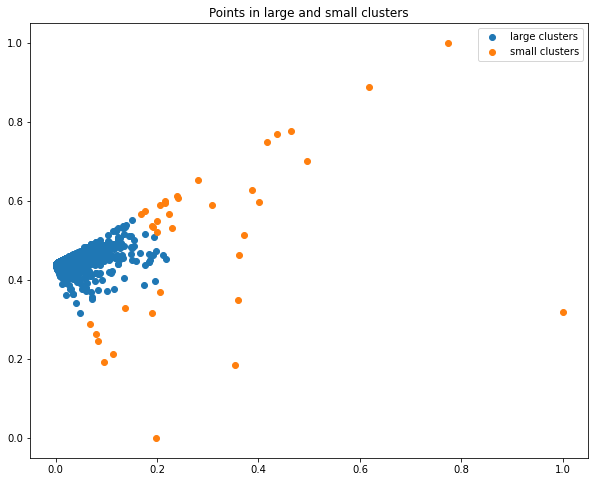

In [137]:
plt.figure(figsize=(10,8))
plt.scatter(x1[labels_in_large_clusters==1], x2[labels_in_large_clusters==1], label=f'large clusters')
plt.scatter(x1[labels_in_large_clusters==0], x2[labels_in_large_clusters==0], label=f'small clusters')
plt.legend()
plt.title("Points in large and small clusters")
plt.show()

We see that points in small clusters is less then the total contaminated points(100). Such that some points in the large clusters will be categoried as outliers. 

# Factor

In [119]:
def get_distance(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

def decision_function(X, labels):
    n=len(labels)
    distances=[]
    for i in range(n):
        p=X[i]
        label = labels[i]
        if label in large_clusters:
            center = km.cluster_centers_[label]
            d=get_distance(p, center)
        else:
            d=None
            for center in large_cluster_centers:
                d_temp = get_distance(p, center)
                if d is None:
                    d=d_temp
                elif d_temp<d:
                    d=d_temp
        distances.append(d)
    distances=np.array(distances)
    return distances

In [120]:
distances = decision_function(X, km.labels_)

In [124]:
threshold=np.percentile(distances, 99)
print(f"threshold is {threshold}")

threshold is 0.04487122042446813


In [125]:
anomaly_labels = (distances>threshold)*1

## Plot

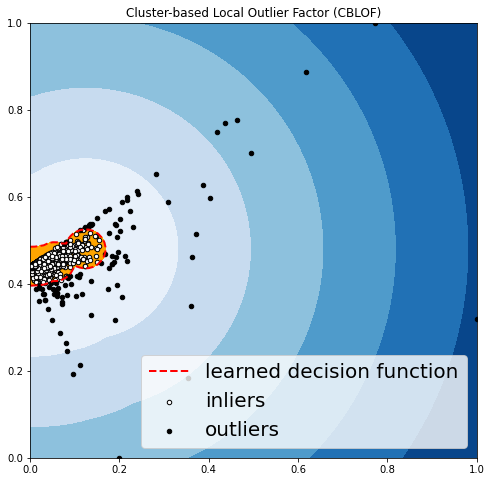

In [126]:
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X_mash = np.c_[xx.ravel(), yy.ravel()]
labels_mash=km.predict(X_mash)
Z = decision_function(X_mash, labels_mash)*-1
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), -threshold, 7),cmap=plt.cm.Blues_r)
plt.contourf(xx, yy, Z, levels=[-threshold, Z.max(), ],colors='orange')
a=plt.contour(xx, yy, Z, levels=[-threshold],linewidths=2, colors='red')
b=plt.scatter(x1[anomaly_labels==0], x2[anomaly_labels==0], c='white', s=20, edgecolor='k', label='Normal')
c=plt.scatter(x1[anomaly_labels==1], x2[anomaly_labels==1], c='black', s=20, label='Anormaly')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right') 
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show()

# Use Weights

We first multiply it.

In [44]:
def get_size(cluster_index):
    return cluster_sizes[cluster_index]
weights=list(map(get_size, km.labels_))
weights=np.array(weights)

new_distances = distances * weights
new_threshold = np.percentile(new_distances, 99)
print(new_threshold)

new_anomaly_labels = (new_distances>new_threshold)*1
print(f"Anormalies: {sum(new_anomaly_labels)}")

80.33156875874546
Anormalies: 100


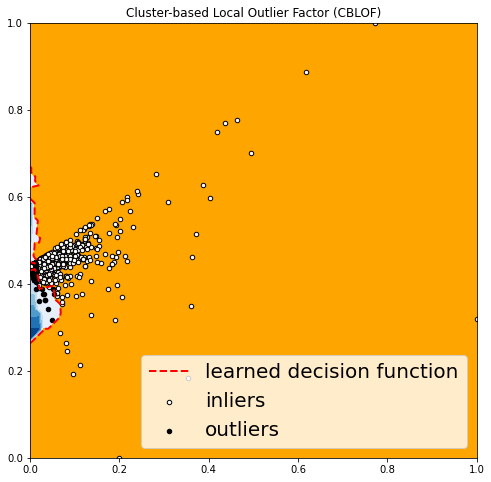

In [45]:
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X_mash = np.c_[xx.ravel(), yy.ravel()]
labels_mash=km.predict(X_mash)
weights=list(map(get_size, labels_mash))
Z = decision_function(X_mash, labels_mash)*-1
Z = Z * weights
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), -new_threshold, 7),cmap=plt.cm.Blues_r)
plt.contourf(xx, yy, Z, levels=[-new_threshold, Z.max(), ],colors='orange')
a=plt.contour(xx, yy, Z, levels=[-new_threshold],linewidths=2, colors='red')
b=plt.scatter(x1[new_anomaly_labels==0], x2[new_anomaly_labels==0], c='white', s=20, edgecolor='k', label='Normal')
c=plt.scatter(x1[new_anomaly_labels==1], x2[new_anomaly_labels==1], c='black', s=20, label='Anormaly')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right') 
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show()

## Fix Weights
We can see that this is totally wrong.

What if we devide it?

In [46]:
def get_size(cluster_index):
    return cluster_sizes[cluster_index]
weights=list(map(get_size, km.labels_))
weights=np.array(weights)

new_distances = distances / weights
new_threshold = np.percentile(new_distances, 99)
print(new_threshold)

new_anomaly_labels = (new_distances>new_threshold)*1
print(f"Anormalies: {sum(new_anomaly_labels)}")

0.00026142180406247146
Anormalies: 100


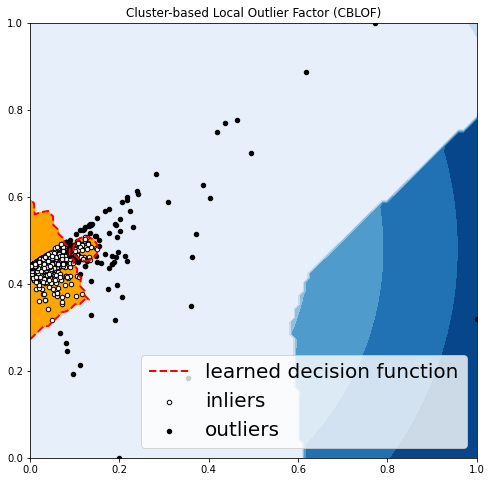

In [47]:
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X_mash = np.c_[xx.ravel(), yy.ravel()]
labels_mash=km.predict(X_mash)
weights=list(map(get_size, labels_mash))
Z = decision_function(X_mash, labels_mash)*-1
Z = Z / weights
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), -new_threshold, 7),cmap=plt.cm.Blues_r)
plt.contourf(xx, yy, Z, levels=[-new_threshold, Z.max(), ],colors='orange')
a=plt.contour(xx, yy, Z, levels=[-new_threshold],linewidths=2, colors='red')
b=plt.scatter(x1[new_anomaly_labels==0], x2[new_anomaly_labels==0], c='white', s=20, edgecolor='k', label='Normal')
c=plt.scatter(x1[new_anomaly_labels==1], x2[new_anomaly_labels==1], c='black', s=20, label='Anormaly')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right') 
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show()

It looks right but the shape is strange. I think maybe KMean is not suitable for weights. 